In [8]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random_graph
import itertools
import collections
import pandas as pd
from pandas.plotting import parallel_coordinates
from matplotlib import rc
import functools
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.sparse as sparse
rc('text', usetex=True)

sns.set(font='serif', style='white')

In [9]:
with open('tmp/kkrwv_testing_gridworld.json') as f:
    data = json.load(f)['data']
coords = random_graph.generate_sorted_grid_coords(16)

In [10]:
awake = lambda i: 1 if i in [0,1] else 0
just_relevant = lambda v: awake(v[0])
tuplify = lambda d: [(k,just_relevant(v)) for k,v in sorted(d.items(), key=lambda i:int(i[0][1::]))]
tuplify_series = lambda lst:(tuplify(d) for d in lst)
def consecutive_pairs(lst_of_lsts):
    a, b = itertools.tee(lst_of_lsts)
    next(b, None)
    return zip(a,b)
def unroll(all_data):
    return itertools.chain(*[tuplify_series(s) for s in all_data])
def unroll_transitions(all_data):
    tuplified_series = (tuplify_series(s) for s in all_data)
    transitions = (consecutive_pairs(s) for s in tuplified_series)
    #return transitions
    return itertools.chain(*transitions)
def count_transitions(g):
    lst = list(g)
    total = len(lst)
    counted = collections.Counter(lst)
    return {k[1]:counts/total for k, counts in counted.items()}
def transition_matrix(all_data):
    transitions = unroll_transitions(data)
    hasher = lambda x,y: (json.dumps(x), json.dumps(y))
    hashable = [hasher(*i) for i in transitions]
    ordered = sorted(hashable, key = lambda i:i[0])
    grouped = {k:count_transitions(g) for k,g in 
               itertools.groupby(ordered, key = lambda i:i[0])}
    return grouped
def count_on_frequency(all_data):
    states = [collections.OrderedDict(state) for state in unroll(data)]
    df = pd.DataFrame(states)
    return df.mean(axis=0).to_dict()
def find_most_common(all_data):
    states = unroll(data)
    hashable = [json.dumps(i) for i in states]
    total = len(hashable)
    counts = collections.Counter(hashable).most_common()
    return [(json.loads(x),y/total) for x,y in counts]
transitions = transition_matrix(data)
counts = find_most_common(data)
def add_count(x,y):
    x.append(('F',y))
    return x
just_points = [add_count(x,y) for x,y in counts]
def to_df(points):
    df = pd.DataFrame([collections.OrderedDict(t) for t in just_points])
    return df
df = to_df(just_points)
dict_data = [v for k,v in df.T.to_dict().items()]
df.head(5)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,F
0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0.012812
1,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0.012396
2,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1,0.012083
3,1,0,1,1,0,0,0,1,1,1,0,1,0,0,1,0,0.010417
4,0,0,1,1,0,1,0,0,0,1,0,0,1,1,1,1,0.010313


In [11]:
def plot(data,coords,ax, num):
    #print(data)
    xs =set([x for x,y in coords])
    ys = set([y for x,y in coords])
    top_coords = list(itertools.product(xs, [max(ys)]))
    top_extensions = [[(x,y),(x,y+5)] for x,y in top_coords]
    bottom_coords = list(itertools.product(xs, [min(ys)]))
    bottom_extensions = [[(x,y),(x,y-5)] for x,y in bottom_coords]
    right_coords= list(itertools.product([max(xs)], ys))
    left_coords = list(itertools.product([min(xs)], ys)) 
    left_extensions = [[(x,y),(x-5,y)] for x,y in left_coords]
    right_extensions = [[(x,y),(x+5,y)] for x,y in right_coords]
    verticals = [list(itertools.product([x],ys)) for x in xs]
    s=250
    horizs = [list(itertools.product(xs,[y])) for y in ys]
    ax.scatter([i[0] for i in coords],[i[1] for i in coords]
              ,facecolor='#ffffff',edgecolor='#525252', linewidth=1,s=s)
    name_to_num = lambda s:int(s[1::])
    active = [name_to_num(i) for i in data if data[i] == 1]
    active_coords= [coords[idx] for idx in active]
    stringifier = lambda s: str(s) if len(str(s))==2 else ' '+str(s)
    for idx, (x,y) in enumerate(coords):
        if (x,y) not in active_coords:
            ax.text(x,y, str(idx), color='#525252',horizontalalignment='center'
                    ,verticalalignment='center', fontsize=11)
    for idx, (x,y) in enumerate(active_coords):
        original_idx = coords.index((x,y))
        ax.text(x,y,str(original_idx), color='#ffffff', horizontalalignment='center'
                ,verticalalignment='center', fontsize=11)
    ax.scatter([i[0] for i in active_coords], [i[1] for i in active_coords]
              ,facecolor='#525252',edgecolor='#525252', linewidth=1,s=s)
    for line in horizs+verticals+top_extensions+bottom_extensions+left_extensions+right_extensions:
        ax.plot([x for x,y in line],[y for x,y in line], color ='#d9d9d9',zorder =0, linestyle ='--')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.text(15.5,-10,str(num+1)+')')
    return ax

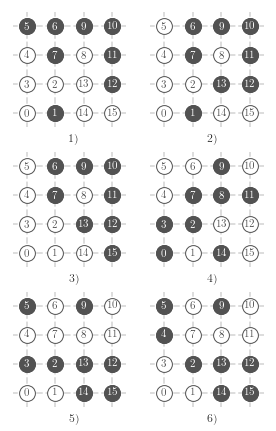

In [12]:
#fig,ax = plt.subplots(1)
fig, axarr = plt.subplots(3, 2)
fig.set_size_inches(4,6)
for idx, ax in enumerate(itertools.chain(*axarr)):
    plot(dict_data[idx], coords, ax, idx)
#plot(dict_data[0],coords,ax)
sns.despine(left=True, bottom=True)
fig.tight_layout()
#sns.despine()

In [23]:
def get_color(cmap, val, minval=0,maxval=1):
    assert minval<=val<=maxval
    factor = (maxval-minval)*255
    return cmap(int(factor*val))
def contrast_text(background):
    r,g,b,a = [int(255*i) for i in background]
    brightness = (r*299+g*587+b*114)/1000
    return "#ffffff" if brightness<175 else '#252525'
def heatplot(data,coords,ax, fig):
    #print(data)
    """
    data: {'S0':p0,'S1':p1...} where p1..pn is the probability of being in that state
    """
    xs =set([x for x,y in coords])
    ys = set([y for x,y in coords])
    top_coords = list(itertools.product(xs, [max(ys)]))
    top_extensions = [[(x,y),(x,y+5)] for x,y in top_coords]
    bottom_coords = list(itertools.product(xs, [min(ys)]))
    bottom_extensions = [[(x,y),(x,y-5)] for x,y in bottom_coords]
    right_coords= list(itertools.product([max(xs)], ys))
    left_coords = list(itertools.product([min(xs)], ys)) 
    left_extensions = [[(x,y),(x-5,y)] for x,y in left_coords]
    right_extensions = [[(x,y),(x+5,y)] for x,y in right_coords]
    verticals = [list(itertools.product([x],ys)) for x in xs]
    s=600
    horizs = [list(itertools.product(xs,[y])) for y in ys]
    name_to_num = lambda s:int(s[1::])
    stringifier = lambda s: str(s) if len(str(s))==2 else ' '+str(s)        
    cmap=plt.get_cmap("Greys")
    our_colors = functools.partial(get_color, cmap)
    ps = [data['S'+str(idx)] for idx,v in enumerate(coords)]
    sc = ax.scatter([x for x,y in coords],[y for x,y in coords],c=ps ,vmin=0,vmax=1,
               edgecolor='#525252', linewidth=1,s=s, cmap=cmap)
    for idx,(x,y) in enumerate(coords):
        val = data['S'+str(idx)]
        color = our_colors(val)
        ax.text(x,y, str(idx), color=contrast_text(color),horizontalalignment='center'
                ,verticalalignment='center', fontsize=11)
    for line in horizs+verticals+top_extensions+bottom_extensions+left_extensions+right_extensions:
        ax.plot([x for x,y in line],[y for x,y in line], color ='#d9d9d9',zorder =0, linestyle ='--')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax_cbar = fig.add_axes([1, 0.2, 0.1, 0.6])
    #ax_cbar = fig.add_axes([0.2,0,0.6,0.1])
    #cbar = plt.colorbar(sc, ax = ax_cbar, orientation='horizontal', fraction=1,label='Proportion of time active',
     #                   ticks=[0,0.2,0.4,0.6,0.8,1])
    #cbar.outline.set_visible(False)
    #cbar.ax.tick_params(direction='out', length=2, width=0.5, colors='#525252',
     #          grid_color='#525252', grid_alpha=0.5)
    #ax_cbar.axes.get_xaxis().set_visible(False)
    #ax_cbar.axes.get_yaxis().set_visible(False)
    #ax_cbar.set_yticklabels([])
    return ax

{'S7': 0.0, 'S13': 0.0, 'S10': 1.0, 'S8': 1.0, 'S5': 0.0, 'S4': 1.0, 'S1': 0.0, 'S11': 0.0, 'S0': 1.0, 'S15': 0.0, 'S6': 1.0, 'S14': 1.0, 'S12': 1.0, 'S9': 0.0, 'S2': 1.0, 'S3': 0.0} {'S7': 1.0, 'S13': 0.0, 'S10': 1.0, 'F': 0.0128125, 'S8': 0.0, 'S5': 1.0, 'S4': 0.0, 'S1': 1.0, 'S11': 1.0, 'S0': 0.0, 'S15': 0.0, 'S6': 1.0, 'S14': 0.0, 'S12': 1.0, 'S9': 1.0, 'S2': 0.0, 'S3': 0.0}


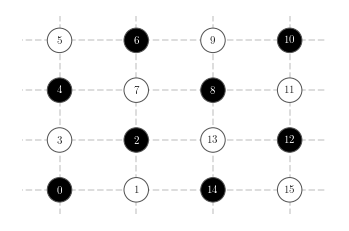

In [24]:
test_data = {'S'+str(i):float(i%2==0) for i in range(16)}
print(test_data, dict_data[0])
fig,ax = plt.subplots(1)
heatplot(test_data, coords, ax, fig)
sns.despine(left=True, bottom=True, top=True,right=True)

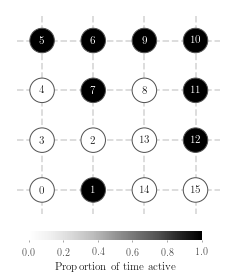

In [15]:
fig,ax= plt.subplots(1)
fig.set_size_inches(4,4)
heatplot(dict_data[0], coords, ax, fig)
sns.despine(left=True, bottom=True, top=True,right=True)

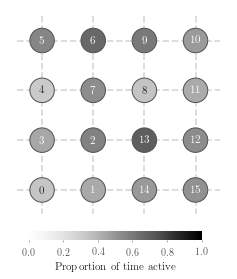

In [16]:
freq_count = count_on_frequency(data)
fig,ax= plt.subplots(1)
fig.set_size_inches(4,4)
heatplot(freq_count, coords, ax,fig)
sns.despine(left=True, bottom=True)

In [17]:
def find_pairwise_correlations(states, relative=False):
    states = pd.DataFrame([collections.OrderedDict(i) for i in unroll(data)])
    total_states = len(states)
    keys = list(states.columns)
    dfs = {k:states[states[k]==1] for k in keys}
    if relative:
        totals = {k:v.mean(axis=0) for k,v in dfs.items()}
    else:
        totals = {k:v.sum(axis=0)/total_states for k,v in dfs.items()} 
    heat_array = np.asarray([v.as_matrix() for k,v in 
                             sorted(totals.items(),
                                    key=lambda i:int(i[0][1::]))])
    return heat_array

/home/jjlong/continuous/venv/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


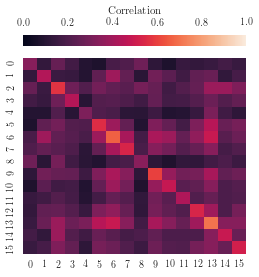

In [19]:
heat_array = find_pairwise_correlations(data, relative=False)
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4.5)
ax = sns.heatmap(heat_array,ax=ax,vmin=0,vmax=1,
                 cbar_kws = dict(use_gridspec=False,location="top",label='Correlation'))

In [27]:
transition_sparse = transition_matrix(data)

In [34]:
transition_sparse[[s for s in set(transition_sparse)][0]]

{'[["S0", 0], ["S1", 0], ["S2", 0], ["S3", 0], ["S4", 1], ["S5", 0], ["S6", 1], ["S7", 1], ["S8", 0], ["S9", 1], ["S10", 0], ["S11", 1], ["S12", 1], ["S13", 1], ["S14", 1], ["S15", 0]]': 0.14925373134328357,
 '[["S0", 0], ["S1", 0], ["S2", 0], ["S3", 1], ["S4", 1], ["S5", 0], ["S6", 1], ["S7", 1], ["S8", 0], ["S9", 1], ["S10", 0], ["S11", 1], ["S12", 1], ["S13", 1], ["S14", 0], ["S15", 0]]': 0.14925373134328357,
 '[["S0", 1], ["S1", 0], ["S2", 0], ["S3", 0], ["S4", 1], ["S5", 0], ["S6", 1], ["S7", 1], ["S8", 0], ["S9", 1], ["S10", 0], ["S11", 1], ["S12", 1], ["S13", 1], ["S14", 0], ["S15", 0]]': 0.5671641791044776,
 '[["S0", 1], ["S1", 0], ["S2", 0], ["S3", 0], ["S4", 1], ["S5", 0], ["S6", 1], ["S7", 1], ["S8", 0], ["S9", 1], ["S10", 1], ["S11", 0], ["S12", 1], ["S13", 1], ["S14", 0], ["S15", 0]]': 0.13432835820895522}

In [138]:
def is_irreducible(sparsemat):
    check_irreducibility = np.linalg.matrix_power(sparsemat.todense(), 100000)
    return np.min(check_irreducibility)>0
def dict_to_sparsemat(d):
    all_states = set(d)
    n= len(all_states)
    hashmap ={state:idx for idx, state in enumerate(all_states)}
    mtx = sparse.dok_matrix((n, n), dtype=np.float64)
    for state, destinations in d.items():
        state_idx = hashmap[state]
        for destination,p in destinations.items():
            destination_idx = hashmap[destination]
            mtx[state_idx, destination_idx] = p
    return hashmap, mtx
def stationary_distribution(sparsemat):
    vals, vecs = sparse.linalg.eigs(sparsemat.T, k=6)
    ind = vals.argsort()
    largest = np.array(vecs[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    probabilities = largest/norm
    largest_3_idx = probabilities.argsort()[::-1][0:6]
    return dict(zip(largest_3_idx, probabilities[largest_3_idx]))
def analyse(d):
    lookup, sparsemat = dict_to_sparsemat(transition_sparse)
    inverted_lookup = {v:k for k,v in lookup.items()}
    pagerank = stationary_distribution(sparsemat)
    res = {inverted_lookup[idx]:p for idx, p in pagerank.items()}
    most_common = [dict(json.loads(i)) for i in res]
    return most_common

In [112]:
lookup, sparsemat = dict_to_sparsemat(transition_sparse)

In [139]:
res = analyse(transition_sparse)

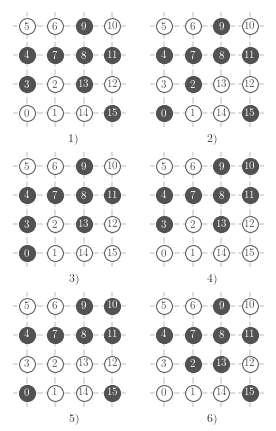

In [140]:
fig, axarr = plt.subplots(3, 2)
fig.set_size_inches(4,6)
for idx, ax in enumerate(itertools.chain(*axarr)):
    plot(res[idx], coords, ax, idx)
sns.despine(left=True, bottom=True)
fig.tight_layout()
#sns.despine()

In [131]:
most_common[0]

[['S0', 1],
 ['S1', 1],
 ['S2', 0],
 ['S3', 0],
 ['S4', 1],
 ['S5', 0],
 ['S6', 0],
 ['S7', 0],
 ['S8', 0],
 ['S9', 1],
 ['S10', 1],
 ['S11', 1],
 ['S12', 0],
 ['S13', 0],
 ['S14', 1],
 ['S15', 1]]

In [171]:
def find_lookup_mode(moderank):
    copied = json.loads(json.dumps(moderank))
    f = copied.get('F')
    del copied['F']
    return json.dumps({k:int(v) for k, v in copied.items()}), f
def crosscheck_pagerank(dict_data, res):
    lookup = dict([find_lookup_mode(i) for i in dict_data])
    return lookup[json.dumps(res)]

In [181]:
crosscheck_pagerank(dict_data, res[2])

0.010833333333333334

In [184]:
res[0]

{'S0': 0,
 'S1': 0,
 'S10': 0,
 'S11': 1,
 'S12': 0,
 'S13': 1,
 'S14': 0,
 'S15': 1,
 'S2': 0,
 'S3': 1,
 'S4': 1,
 'S5': 0,
 'S6': 0,
 'S7': 1,
 'S8': 1,
 'S9': 1}